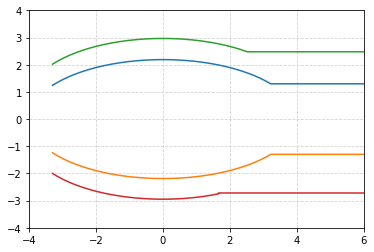

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Shape_Visualisation import draw_shape
%matplotlib inline

In [2]:
df=pd.read_csv("urop.csv")


# extract healthy echo data
df = df.drop(["IDshort",'SERNO','HistoCode'], 1)
mask=df["Cardiac_Category (0=good; 1=poor)"]==0
healthy_df=df[mask]
echo=healthy_df.iloc[:,19:55]

# fill in missing data
for col in echo.columns:
    echo[col].fillna(echo[col].mean(),inplace=True)

    
# data that form part of cardiac geometry    
left_ventricle=echo.iloc[:,1:8]
aorta=echo.iloc[:,8:9]
left_atrium=echo.iloc[:,9:10]
sinus=echo.iloc[:,-4:-2]

In [3]:
# Step 1 : Standardize/normalise the data

from sklearn.preprocessing import StandardScaler

In [4]:
norm_lv=StandardScaler().fit_transform(left_ventricle)

In [5]:
# Check if data is normalized

np.mean(norm_lv) , np.std(norm_lv)

(-5.014884954769414e-16, 1.0)

In [6]:
# Visualisation of standardized data

lv_df=pd.DataFrame(norm_lv,columns=left_ventricle.columns)
lv_df.head(3)

,IVSD__cm,IVSS__cm,LVIDD_cm,LVIDS_cm,LVPWD_cm,LVPWS_cm,LVOT__cm
0,-0.674031,-1.301265,-0.641467,0.520507,-1.043695,-1.148882,-0.065609
1,1.899542,1.506259,2.934855,3.127819,2.881844,0.994111,0.651986
2,-0.674031,0.102497,-0.130564,-0.081180,0.264818,-0.434551,-0.266535


In [7]:
from sklearn.decomposition import PCA
from math import pi

In [8]:
# Apply PCA on normalised dataset


class convers_pca():
    def __init__(self, no_of_components):
        self.no_of_components = no_of_components
        self.eigen_values = None
        self.eigen_vectors = None
        
    def transform(self, x):
        return np.dot(x - self.mean, self.projection_matrix.T)
    
    def inverse_transform(self, x):
        return np.dot(x, self.projection_matrix) + self.mean
    
    def fit(self, x):
        if self.no_of_components is None:
            self.no_of_components = x.shape[1]
        else:
            self.no_of_components = self.no_of_components
            
            
        self.mean = np.mean(x, axis=0)
        
        cov_matrix = np.cov(x - self.mean, rowvar=False)
        
        self.eigen_values, self.eigen_vectors = np.linalg.eig(cov_matrix)
        self.eigen_vectors = self.eigen_vectors.T
        
        self.sorted_components = np.argsort(self.eigen_values)[::-1]
        
        self.projection_matrix = self.eigen_vectors[self.sorted_components[:self.no_of_components]]
        self.explained_variance = self.eigen_values[self.sorted_components[:self.no_of_components]]
        self.explained_variance_ratio = self.explained_variance / self.eigen_values.sum()

In [9]:
# Check how many components are required to retain 98% variance

pca=PCA(0.98)
pca_lv=pca.fit_transform(norm_lv)
pca.n_components_

6

In [10]:
# Create PCA with 6 components
pca=convers_pca(no_of_components=6)
pca.fit(norm_lv)

In [11]:
# x = x_m + Pb
# x_m --> mean 
# P   --> t eigenvectors (p1|p2|....|pt)
# b   --> t vectors of weights (b1|b2|....|bt)T ,  -3 sqrt(lambda) < b_i < 3 sqrt(lambda)

x_m=np.array(left_ventricle.mean())


In [12]:
p=pca.projection_matrix.T

In [13]:
b=pca.explained_variance_ratio
lower_limit=-2*np.sqrt(b)
upper_limit=2*np.sqrt(b)

In [14]:
#adjust 1st mode, set all other paramters to zero

b1_low=np.concatenate((lower_limit[0],np.zeros(5)),axis=None).T
b1_high=np.concatenate((upper_limit[0],np.zeros(5)),axis=None).T
b2_low=np.concatenate((np.zeros(1),lower_limit[1],np.zeros(4)),axis=None).T
b2_high=np.concatenate((np.zeros(1),upper_limit[1],np.zeros(4)),axis=None).T

In [15]:
x1_low=x_m+ np.matmul(p,b1_low)
x1_high=x_m+ np.matmul(p,b1_high)
x2_low=x_m+ np.matmul(p,b2_low)
x2_high=x_m+ np.matmul(p,b2_high)

In [16]:
x1_low,x_m,x1_high

(array([1.31605508, 1.65304313, 4.94685027, 2.82398866, 1.29871838,
        1.9353307 , 2.47093863]),
 array([0.77857143, 1.17809524, 4.37666667, 2.44047619, 0.75952381,
        1.42166667, 2.02285714]),
 array([0.24108778, 0.70314734, 3.80648306, 2.05696372, 0.22032924,
        0.90800263, 1.57477565]))

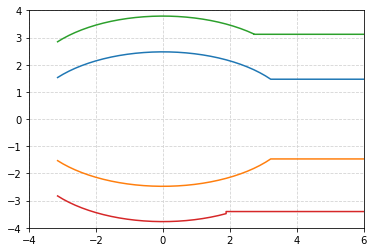

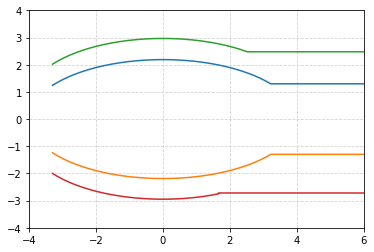

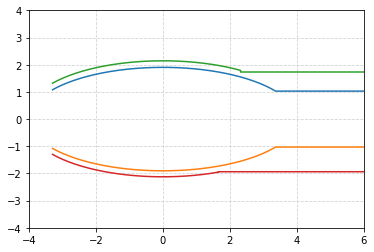

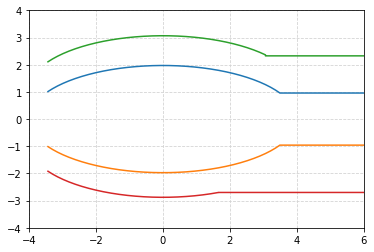

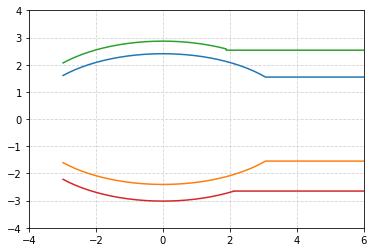

(None, None, None, None, None)

In [17]:
# use draw_shape() method on x1_low,x_m,x1_high

draw_shape(x1_low),draw_shape(x_m),draw_shape(x1_high),draw_shape(x2_low),draw_shape(x2_high)